# Clothing Image Classification

#### Team Name: Blitz
#### Team ID: 6460727
#### Members: Vivaswat Sinha, Abhishek Kumar, Dhruv, Apoorv Garg
### =======================================

##### Welcome to Team Blitz Myntra HackerRamp Hackerthon Submission.
We would Like to present Our Project "Clothing Recommendation System" developed using Densenet.


## Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
import pickle
from tensorflow.keras.layers import Input, Dense, Dropout
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Limiting GPU usage to 90%
#### Prevent sudden crashes

In [2]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.set_session(tf.compat.v1.Session(config=config))

## Functions

In [3]:
def load_data(path):
    '''
        This function is used to load the images and their file names to a list.
        
        parameters:
            path: path to the images directory.
        
        variable:
            images: stores the images.
                dimension: (num_img, 1, 224, 244, 3)
            
            image_names: stores the name of image files
                dimension: (num_img, 1)
        
        return:
            images, image_names
    '''
    
    images = []
    image_names = []
    
    # starting timer
    startTime = time.time()
    print('Loading Images!')
    
    count = 0
    
    # accessing image directory
    for subfolder in os.listdir(path):
        
        # accessing image subfolder
        folder = os.path.join('Images', subfolder)
        for file in os.listdir(folder):
            
            # loading image file
            img = image.load_img(os.path.join(folder, file), target_size=(224, 224))
            
            # converting image into an array of dimension (1, img_dim)
            img = np.array([image.img_to_array(img)])
            
            # saving image and image name in arrays
            image_names.append(file)
            images.append(img)
            
            count += 1
            if count%100 == 0:
                print('Loaded {} images'.format(count))
    print('Loading Done!')
    print('Time Taken to Load Images: {0:.2f} seconds'.format(time.time() - startTime))
    
    return images, image_names

In [4]:
def plot_img(images, image_names):
    '''
        This function is used to plot some of the images using matplotlib.
        
        parameters:
            images: array of images.
            image_names: array of all image file names.
        
        variable:
            fig: matplotlib figure
            ax: axis of matplotlib figure
    '''
    
    # creating figure with 6 subplots
    fig, ax = plt.subplots(2, 3)
    
    # setting size of figure
    fig.set_size_inches(9, 5)
    
    # setting subplot spacing
    plt.subplots_adjust(hspace=0.4, wspace=1)

    # plotting 6 random images
    for i in range(2):
        for j in range(3):
            index = random.randint(1, len(image_names))
            ax[i,j].text(-10, -20, image_names[index-1])
            ax[i,j].imshow(images[index-1][0]/255.)

In [5]:
def load_tag_data(file, image_names):
    '''
        This function is used to load the tags for training. 
        The tags are then converted to multiple lists and dictionary for use.
        
        parameter:
            file: path to csv file.
            image_names: array containing names of all image files.
        
        variable:
            DatasetCSV: pandas dataframe that stores the csv data.
            Class: list containing all the Class for classification.
            ClassItem: dictionary mapping Class with a list of all its distinct values.
            Tags: numpy array containing the different tags for an image.
                dimension: (num_img, 3)
            fileName: numpy array containing name of image file.
                dimension: (num_img, 1)
            img_tag_map: dictionary mapping file name with their tags.
                format: 
                    filename: tags
        
        return:
            Class, ClassItem, img_tag_map, Tags, fileName
    '''
    
    print('Loading CSV')
    
    # reading csv file
    DatasetCSV = pd.read_csv(file)
    
    print('CSV loaded')
    # extracting classes
    Class = list(DatasetCSV.columns[1:])
    
    img_tag_map = {}
    fileName = []
    Tags = []
    ClassItem = {}
    
    # mapping image file name with tags
    for index, row in DatasetCSV.iterrows():
        img_tag_map[row['filename']] = np.array([row['type'], row['subType'], row['color']])
        fileName.append(row['filename'])
    
    # ordering tags according to dataset
    for name in image_names:
        Tags.append(img_tag_map[name])
    Tags = np.array(Tags)
    
    # creating ClassItem dictionary
    for index in range(Tags.shape[1]):
        ClassItem[Class[index]] = np.unique(Tags[:, index])
    
    print("Total Number of Classes: {}".format(len(Class)))
    for cl in Class:
        print("{}: {}".format(cl, ClassItem[cl]) )

    print('Total Number of Images: {}'.format(len(fileName)))
    
    return Class, ClassItem, img_tag_map, Tags, fileName


In [6]:
def encode_images(images, names):
    '''
        This function encodes the image into a 1D Vector which will be used for classification later. If the encoded
        
        parameters:
            images: array of all images
            names: name of images
        variable:
            model: DenseNet121 model with weights of imagenet. The last  layer of the densenet model are removed.
            X_encoded: numpy array containing the encoded image vectors.
                dimension: (num_img, 1024)
            name_encode_map: dictionary mapping image file name and encoded vector
        
        return:
            model, X_encoded
    '''
    
    # loading densenet121 model
    model = DenseNet121(weights='imagenet')
    # removing last Layer
    model = Model(model.input, model.layers[-2].output)
    
    # Starting timer
    startTime = time.time()
    name_encode_map = {}
    X_encoded = []
    
    # If images are already encoded, then load then from pickle file
    if('encoded_train_data.pkl' in os.listdir('saved') and 'encoded_train_array.pkl' in os.listdir('saved')):
        print('encoded data already present!')
        print('reading files....')
        
        # loading name_encode_map
        with (open('saved/encoded_train_data.pkl', "rb")) as openfile:
            name_encode_map = pickle.load(openfile)

        # Loading X_encoded
        with open('saved/encoded_train_array.pkl', 'rb') as f:
            while True:
                try:
                    X_encoded.append(pickle.load(f))
                except EOFError:
                    break
    # Else encode all the images using densenet model
    else:
        print('Starting Encoding Process!')
        for index, img in enumerate(images):
            
            # Encoding image
            vec = model.predict(img)
            
            # reshaping vector into 1D vector
            vec.reshape(-1)
            
            # mapping image vector to image file name
            name_encode_map[names[index]] = vec[0]
            
            # adding image vector to training array
            X_encoded.append(vec[0])
            
            if index%200 == 0:
                curTime = time.time()
                print("{0} images Encoded... Time Elapsed: {1:.2f} seconds".format(index, curTime - startTime))

        # saving encoded data
        with open('saved/encoded_train_data.pkl', 'wb') as f:
            pickle.dump(name_encode_map, f)
        with open('saved/encoded_train_array.pkl', 'wb') as f:
            pickle.dump(X_encoded, f)
    endTime = time.time()
    print("Done Encoding... Total Time: {0:.2f}".format(endTime - startTime))
    
    X_encoded = np.array(X_encoded)
    X_encoded = X_encoded.reshape((-1, 1024))
    
    return model, X_encoded

In [18]:
def create_model(Class, X_train, Y_train, epoch=100, batch=25, opti='adam'):
    '''
        This Function creates a simple ANN for classification.
        
        parameters:
            Class: list of all Classes.
            X_train: array of images to train.
            Y_train: labels of images to train.
            epoch: numer of epochs.
            batch: batch size.
            opti: optimizer.
        
        variable:
            model_1: simple ANN network
        
        return:
            model_1
    '''
    
    # Creating model
    model_1 =Input(shape=(1024,))
    dense1 = Dense((512), activation='relu')(model_1)
    drop = Dropout(0.3)(dense1)
    dense2 = Dense((256), activation='relu')(drop)
    dense3 = Dense((64), activation='relu')(dense2)
    output = Dense(len(ClassItem[Class]), activation='softmax')(dense3)
    
    # training model
    model_1 = Model(model_1, output)
    model_1.compile(optimizer=opti, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_1.fit(X_train, Y_train, epochs = epoch, batch_size=batch, shuffle=True, validation_split=0.2)
    
    return model_1

In [19]:
def train(Class, X_train, Y_train, num_epoch, batch_size):
    '''
        This function is used to train multiple models for all the classes. 
        It also saves the model and LabelEncoder data in h5 and npy file respectively for prediction.
        
        parameters:
            Class: list containing all the classes
                dimension: (3,)
            X_train: image vectors.
                dimension: (num_img, 1024)
            Y_train: Tags.
                dimension: (num_img, 3)
            num_epoch: number of epochs to train on.
            batch_size: batch size.
        
        variable:
            label_encoder: LabelEncoder object.
            newMode: model trained for a class.
            models: list containing all class models.
        
        return:
            models
                
    '''
    models = []
    for i in range(Y_train.shape[1]):
        
        # encoding Y_train
        label_encoder = LabelEncoder()
        Y_train = Y_train[:, i]
        Y_train = np.array(label_encoder.fit_transform(Y_train))
        
        # training model on current class
        newModel = create_model(Class[i], X_train, Y_train, num_epoch, batch_size)
        models.append(newModel)
        
        newModel.save('saved/model/model_'+Class[i]+'.h5')
        np.save("saved/encoder/"+Class[i]+"_label.npy", label_encoder.classes_)
    
    return models

## Training Model

In [9]:
images, image_names = load_data('Images')

Loading Images!
Loaded 100 images
Loaded 200 images
Loaded 300 images
Loaded 400 images
Loaded 500 images
Loaded 600 images
Loaded 700 images
Loaded 800 images
Loaded 900 images
Loaded 1000 images
Loaded 1100 images
Loaded 1200 images
Loaded 1300 images
Loaded 1400 images
Loaded 1500 images
Loaded 1600 images
Loaded 1700 images
Loaded 1800 images
Loaded 1900 images
Loaded 2000 images
Loaded 2100 images
Loaded 2200 images
Loaded 2300 images
Loaded 2400 images
Loaded 2500 images
Loaded 2600 images
Loaded 2700 images
Loaded 2800 images
Loaded 2900 images
Loaded 3000 images
Loaded 3100 images
Loaded 3200 images
Loaded 3300 images
Loaded 3400 images
Loaded 3500 images
Loaded 3600 images
Loaded 3700 images
Loaded 3800 images
Loaded 3900 images
Loaded 4000 images
Loaded 4100 images
Loaded 4200 images
Loaded 4300 images
Loaded 4400 images
Loaded 4500 images
Loaded 4600 images
Loaded 4700 images
Loaded 4800 images
Loaded 4900 images
Loaded 5000 images
Loaded 5100 images
Loaded 5200 images
Loade

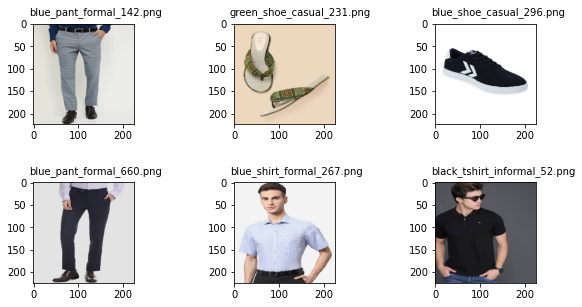

In [10]:
plot_img(images, image_names)

In [11]:
Class, ClassItem, desc, Y_train, filename = load_tag_data('Dataset.csv', image_names)

Loading CSV
CSV loaded
Total Number of Classes: 3
type: ['casual' 'formal' 'informal']
subType: ['pant' 'shirt' 'shoe' 'tshirt']
color: ['black' 'blue' 'green' 'orange' 'red' 'white' 'yellow']
Total Number of Images: 18035


In [13]:
Densenet, X_train = encode_images(images, image_names)

Starting Encoding Process!
0 images Encoded... Time Elapsed: 2.15 seconds
200 images Encoded... Time Elapsed: 33.08 seconds
400 images Encoded... Time Elapsed: 65.97 seconds
600 images Encoded... Time Elapsed: 97.91 seconds
800 images Encoded... Time Elapsed: 128.54 seconds
1000 images Encoded... Time Elapsed: 159.25 seconds
1200 images Encoded... Time Elapsed: 190.08 seconds
1400 images Encoded... Time Elapsed: 221.28 seconds
1600 images Encoded... Time Elapsed: 252.05 seconds
1800 images Encoded... Time Elapsed: 282.73 seconds
2000 images Encoded... Time Elapsed: 313.87 seconds
2200 images Encoded... Time Elapsed: 344.85 seconds
2400 images Encoded... Time Elapsed: 376.41 seconds
2600 images Encoded... Time Elapsed: 406.76 seconds
2800 images Encoded... Time Elapsed: 437.29 seconds
3000 images Encoded... Time Elapsed: 467.50 seconds
3200 images Encoded... Time Elapsed: 497.73 seconds
3400 images Encoded... Time Elapsed: 528.12 seconds
3600 images Encoded... Time Elapsed: 558.35 secon

In [ ]:
models = train(Class, X_train, Y_train, 150, 20)

Epoch 1/150
722/722 [==============================] - 4s 5ms/step - loss: 0.7134 - accuracy: 0.7255 - val_loss: 0.4895 - val_accuracy: 0.8029
Epoch 2/150
722/722 [==============================] - 4s 5ms/step - loss: 0.4317 - accuracy: 0.8090 - val_loss: 0.3607 - val_accuracy: 0.8506
Epoch 3/150
722/722 [==============================] - 3s 5ms/step - loss: 0.3903 - accuracy: 0.8321 - val_loss: 0.2543 - val_accuracy: 0.9179
Epoch 4/150
722/722 [==============================] - 3s 5ms/step - loss: 0.3663 - accuracy: 0.8487 - val_loss: 0.2953 - val_accuracy: 0.9035
Epoch 5/150
722/722 [==============================] - 3s 5ms/step - loss: 0.3497 - accuracy: 0.8520 - val_loss: 0.2757 - val_accuracy: 0.9093
Epoch 6/150
714/722 [============================>.] - ETA: 0s - loss: 0.3271 - accuracy: 0.8681